<a href="https://colab.research.google.com/github/andandandand/practical-computer-vision/blob/main/notebooks/Dropout_Visualization_on_MNIST_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dropout Visualization on MNIST Images

#### Author: Antonio Rueda-Toicen
**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

Dropout is a [regularization](https://developers.google.com/machine-learning/glossary#regularization) technique for neural networks that randomly deactivates a fraction of neuron outputs during training to prevent complex [co-adaptations](https://developers.google.com/machine-learning/glossary#co-adaptation) on training data. This forces the network to learn more robust features and improves generalization to unseen data, effectively reducing [overfitting](https://developers.google.com/machine-learning/glossary#overfitting).

For a comprehensive understanding, refer to the original paper: [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/v15/srivastava14a.html).


## Key Insights about Dropout
1. Dropout randomly zeros elements of the input tensor with probability $p$ during training.
2. For any given input image or activation map, the specific pixels that are zeroed are different on each training run. This prevents what is called 'co-adaptation' (i.e., the model overfiffing on a particular configuration of activations).
3. During evaluation ([`model.eval()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval)), dropout is disabled to ensure consistent outputs. This helps us verify that training is effective.
4. Different dropout probabilities affect how much information is preserved during training.
5. Higher dropout probabilities lead to more aggressive regularization but might lose more useful information.
6. The "optimal" amount of dropout for a particular problem and model is a [hyperparameter](https://developers.google.com/machine-learning/glossary#hyperparameter) that needs to be explored with a [validation set](https://developers.google.com/machine-learning/glossary#validation-set).


![](https://raw.githubusercontent.com/andandandand/practical-computer-vision/refs/heads/main/docs/dropout_train_vs_eval.png)

Selected digit: 0
Image shape: torch.Size([1, 28, 28])


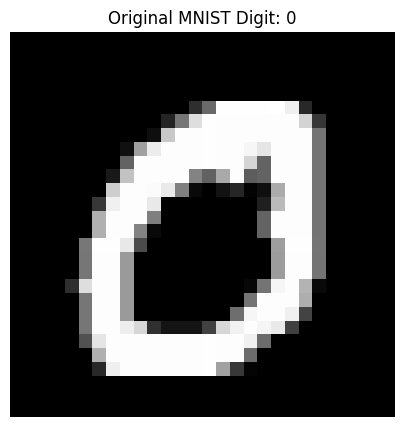

In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Define transformations
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True) # Convert images to PyTorch tensors
])

# Load MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Let's select a single digit for our demonstration
digit_index = 51  # We'll use the 51st image from the dataset
single_digit, label = mnist_dataset[digit_index]

# Print information about the digit
print(f"Selected digit: {label}")
print(f"Image shape: {single_digit.shape}")

# Visualize the original digit
plt.figure(figsize=(5, 5))
plt.imshow(single_digit.squeeze(), cmap='gray')
plt.title(f"Original MNIST Digit: {label}")
plt.axis('off')
plt.show()



In [ ]:
def visualize_dropout_effect(input_image, num_runs=10, dropout_prob=0.5):
    # Create a dropout layer
    dropout_layer = nn.Dropout(p=dropout_prob)
    dropout_layer.train()  # Set to train mode to enable dropout, eval() turns it off

    # Create a figure to display results
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Multiple Runs with Dropout (p={dropout_prob})", fontsize=16)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Run the dropout layer multiple times and visualize results
    for i in range(num_runs):
        # Forward pass with dropout
        with torch.no_grad():
            # Apply dropout to the flattened image
            flattened = input_image.view(1, -1)
            output = dropout_layer(flattened)
            # Reshape back to original image dimensions
            output = output.view(1, 1, 28, 28)

        # Display result
        axes[i].imshow(output.squeeze().numpy(), cmap='gray')
        axes[i].set_title(f"Run {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

## Visualize the effect of different dropout probabilities


Visualizing multiple runs with dropout probability = 0.2


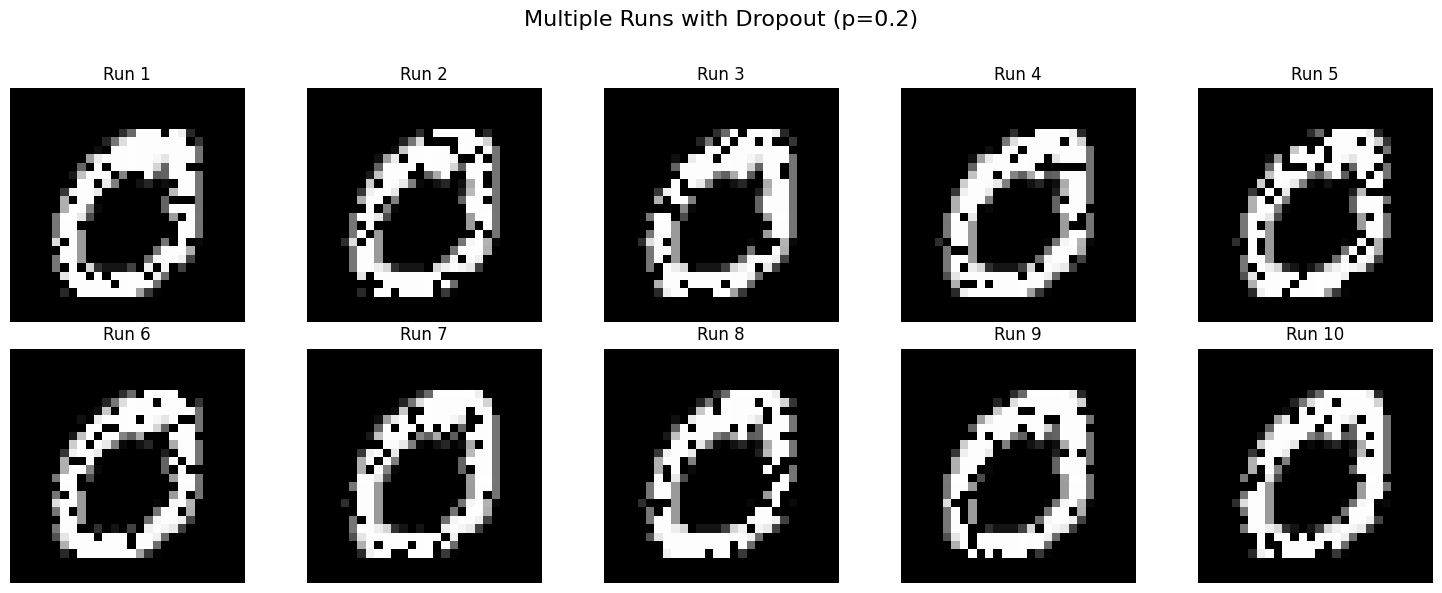


Visualizing multiple runs with dropout probability = 0.5


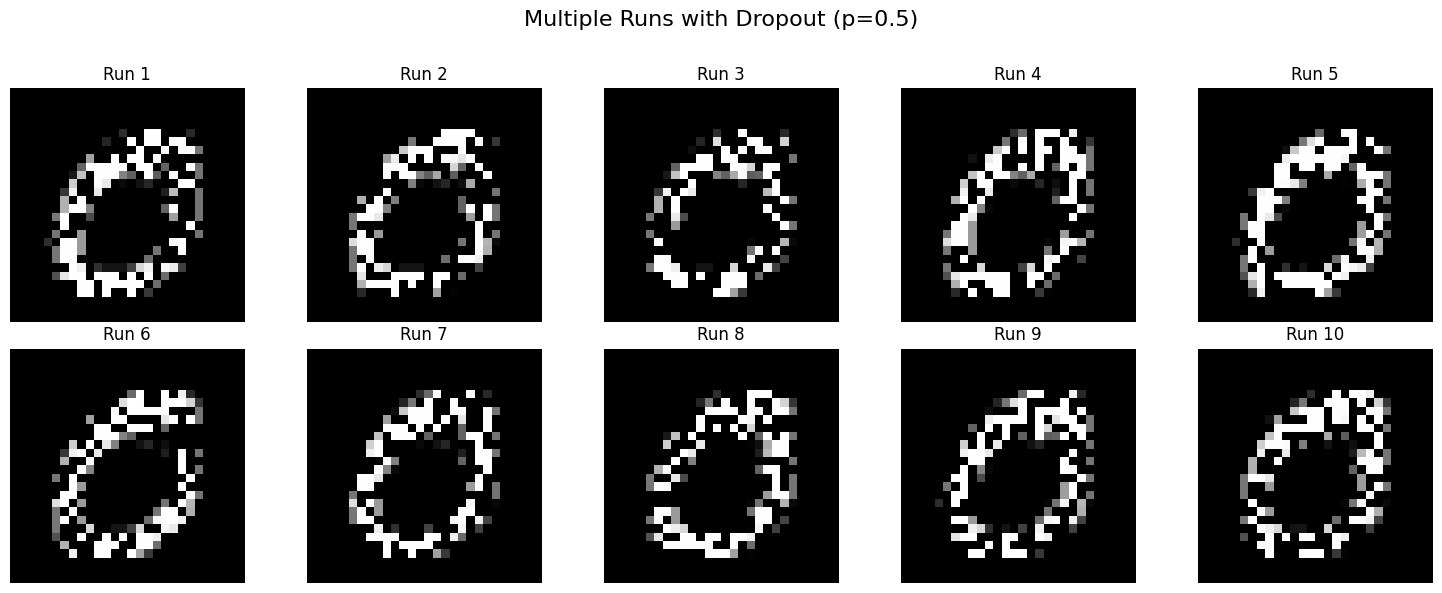


Visualizing multiple runs with dropout probability = 0.8


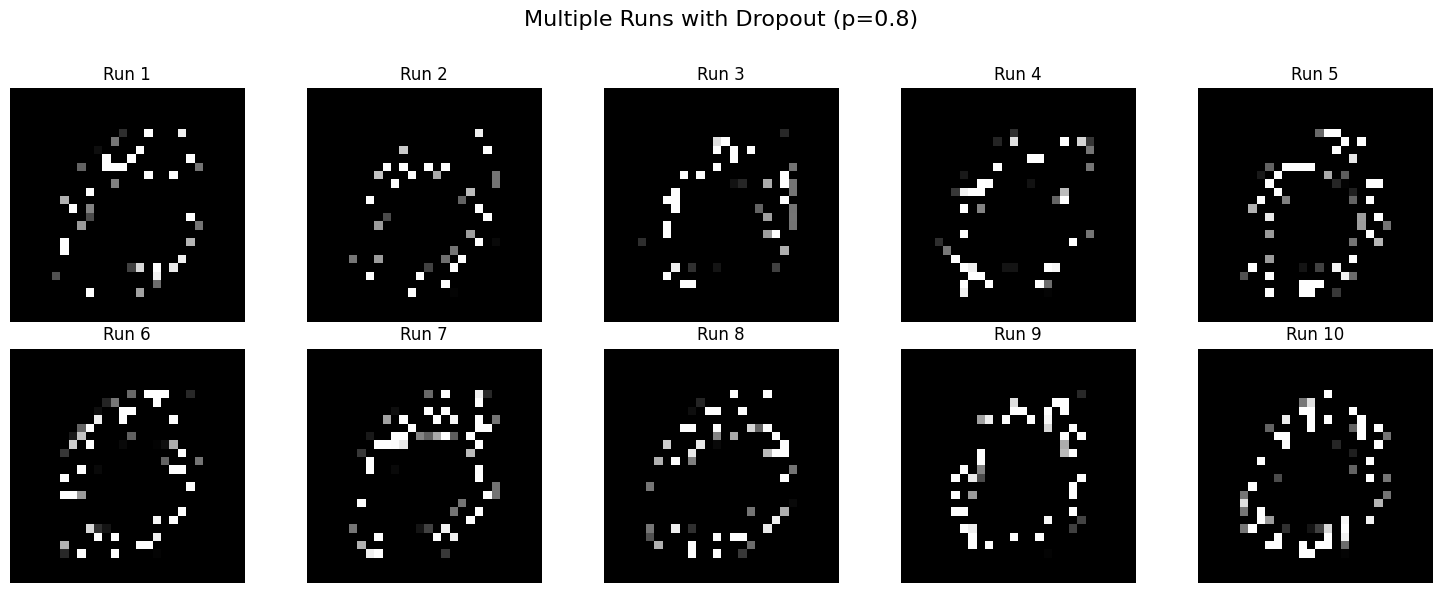

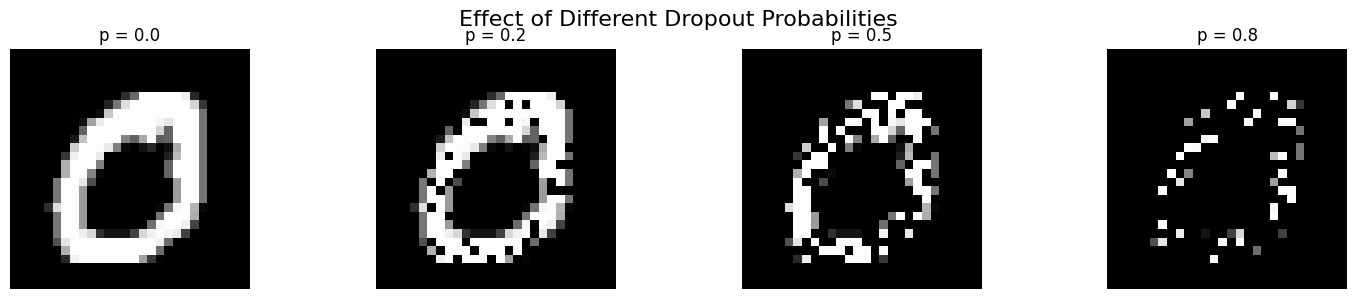

In [ ]:
# Function to visualize the effect of different dropout probabilities
def visualize_different_dropout_probs(input_image, probs=[0.0, 0.2, 0.5, 0.8]):
    # Create a figure to display results
    fig, axes = plt.subplots(1, len(probs), figsize=(15, 3))
    fig.suptitle("Effect of Different Dropout Probabilities", fontsize=16)

    # For each dropout probability
    for i, prob in enumerate(probs):
        # Create dropout layer with the given probability
        dropout_layer = nn.Dropout(p=prob)
        dropout_layer.train()  # Set to train mode to enable dropout

        # Forward pass
        with torch.no_grad():
            # Apply dropout to the flattened image
            flattened = input_image.view(1, -1)
            output = dropout_layer(flattened)
            # Reshape back to original image dimensions
            output = output.view(1, 1, 28, 28)

        # Display result
        axes[i].imshow(output.squeeze().numpy(), cmap='gray')
        axes[i].set_title(f"p = {prob}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Visualize the effect of multiple runs with different dropout probabilities
dropout_probs = [0.2, 0.5, 0.8]
for prob in dropout_probs:
    print(f"\nVisualizing multiple runs with dropout probability = {prob}")
    visualize_dropout_effect(single_digit, num_runs=10, dropout_prob=prob)

# Visualize different dropout probabilities in a single plot
visualize_different_dropout_probs(single_digit)

## Visualizing the activation map


The activation map visualization shows which features are most frequently preserved across multiple runs at different dropout probabilities.

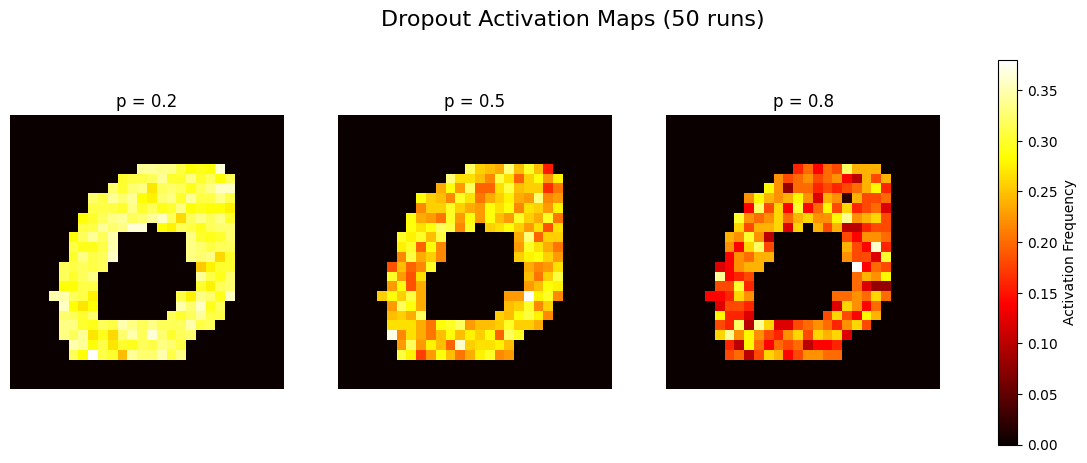

In [ ]:
# Now let's create a visualization to show how dropout affects feature activation

def visualize_dropout_activation_map_side_by_side(input_image, probs=[0.2, 0.5], num_runs=50):
    # Create a figure with subplots side by side
    fig, axes = plt.subplots(1, len(probs), figsize=(5 * len(probs), 5))
    fig.suptitle(f'Dropout Activation Maps ({num_runs} runs)', fontsize=16)

    for i, prob in enumerate(probs):
        # Create a dropout layer
        dropout_layer = nn.Dropout(p=prob)
        dropout_layer.train()  # Enable dropout

        # Initialize an activation map (to count how often each pixel is activated)
        # Initialize with shape [1, 28, 28] to match input_image
        activation_map = torch.zeros_like(input_image)

        # Run the dropout multiple times
        for _ in range(num_runs):
            # Forward pass with dropout
            with torch.no_grad():
                # Apply dropout to the flattened image
                flattened = input_image.view(1, -1)
                output = dropout_layer(flattened)
                # Reshape back to original image dimensions
                mask = output.view(1, 1, 28, 28) # mask has shape [1, 1, 28, 28]

                # Add to activation map (count active pixels)
                # Squeeze the mask to match the shape of activation_map before adding
                activation_map += (mask.squeeze(1) != 0).float() # Squeeze the channel dimension

        # Normalize activation map
        activation_map = activation_map / num_runs

        # Display the heat map on the current subplot
        im = axes[i].imshow(activation_map.squeeze().numpy(), cmap='hot')
        axes[i].set_title(f'p = {prob}')
        axes[i].axis('off')

    # Add a single colorbar for all subplots
    fig.colorbar(im, ax=axes.ravel().tolist(), label='Activation Frequency')
    plt.show()

# Visualize dropout activation maps for different probabilities side by side
visualize_dropout_activation_map_side_by_side(single_digit, probs=[0.2, 0.5, 0.8], num_runs=50)

## Comparing `model.train()` vs `model.eval()` mode

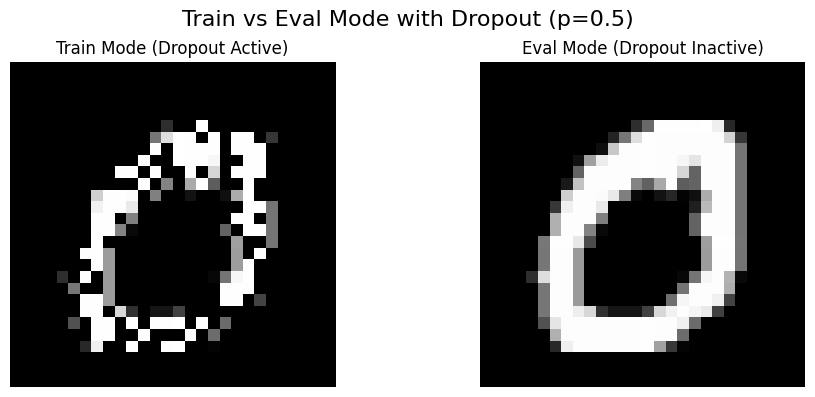

In [ ]:
# Function to compare train vs eval mode
def compare_train_vs_eval_mode(input_image, dropout_prob=0.5):
    # Create a dropout layer
    dropout_layer = nn.Dropout(p=dropout_prob)

    # Create a figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Train vs Eval Mode with Dropout (p={dropout_prob})", fontsize=16)

    # Train mode (dropout active)
    dropout_layer.train()
    with torch.no_grad():
        # Apply dropout to the flattened image
        flattened = input_image.view(1, -1)
        train_output = dropout_layer(flattened)
        # Reshape back to original image dimensions
        train_output = train_output.view(1, 1, 28, 28)

    # Eval mode (dropout inactive)
    dropout_layer.eval()
    with torch.no_grad():
        # Apply dropout to the flattened image
        flattened = input_image.view(1, -1)
        eval_output = dropout_layer(flattened)
        # Reshape back to original image dimensions
        eval_output = eval_output.view(1, 1, 28, 28)

    # Display results
    axes[0].imshow(train_output.squeeze().numpy(), cmap='gray')
    axes[0].set_title("Train Mode (Dropout Active)")
    axes[0].axis('off')

    axes[1].imshow(eval_output.squeeze().numpy(), cmap='gray')
    axes[1].set_title("Eval Mode (Dropout Inactive)")
    axes[1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Compare train vs eval mode for dropout
compare_train_vs_eval_mode(single_digit, dropout_prob=0.5)